# Notebook: 01_modelo_sentimiento_reviews

Este notebook tiene como objetivo construir un modelo de clasificación supervisada que sea capaz de predecir si un comentario de un producto es **positivo**, **neutro** o **negativo** basándose únicamente en el texto del comentario (`review_text`).

Para ello, se seguirá un enfoque paso a paso que incluye:

1. Carga y exploración de los datos preparados previamente.
2. Generación de una variable de sentimiento real a partir de la valoración numérica (`rating`) de los usuarios.
3. Preprocesamiento del texto (limpieza y normalización).
4. Transformación del texto en vectores numéricos mediante TF-IDF.
5. Entrenamiento de un modelo de clasificación lineal (Logistic Regression).
6. Evaluación del rendimiento del modelo mediante métricas estándar (accuracy, matriz de confusión, F1 score).
7. Comparación entre el sentimiento predicho por el modelo y el sentimiento real derivado del `rating`.

Este notebook constituye el primer paso en el análisis de los comentarios de clientes con el objetivo final de comprender mejor **qué valoran positiva o negativamente los usuarios en los productos**.


In [1]:
# Paso 0: Configuración inicial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

# Configuración de estilo para visualizaciones
sns.set(style="whitegrid")

# -------------------------
# Cargar automáticamente el archivo CSV exportado por Spark
# -------------------------
import os

# Construir ruta absoluta desde notebooks/
base_path = os.path.abspath("../data/exploitation/modelos_input/reviews_base_csv")
file_list = [f for f in os.listdir(base_path) if f.endswith(".csv")]

if not file_list:
    raise FileNotFoundError("No se encontró ningún archivo .csv en la carpeta indicada.")

# Leer el archivo CSV con pandas
file_path = os.path.join(base_path, file_list[0])
df = pd.read_csv(file_path)

# Vista previa
df.head()


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/judmartz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review_text,rating
0,i would not repurchase as there are better one...,3
1,"i love it, the flavour and the little applicat...",5
2,i can not live with out this product it leaves...,5
3,"before buying this product, you have to unders...",5
4,this lip mask is so good for dehydrated lips. ...,5


In [2]:
# Paso 1: Crear la columna sentimiento_real a partir del rating

# Asegurarse de que la columna rating sea numérica
df["rating"] = pd.to_numeric(df["rating"], errors="coerce")


# Definir una función que clasifique según la lógica establecida
def clasificar_sentimiento_binario(rating):
    if rating in [1, 2]:
        return "negativo"
    elif rating in [3, 4, 5]:
        return "positivo"
    else:
        return "desconocido"

# Aplicar la función a la columna rating
df["sentimiento_real"] = df["rating"].apply(clasificar_sentimiento_binario)
df = df[df["sentimiento_real"] != "desconocido"]

# Verificamos los resultados
df[["rating", "sentimiento_real"]].head(10)


,rating,sentimiento_real
0,3.0,positivo
1,5.0,positivo
2,5.0,positivo
3,5.0,positivo
4,5.0,positivo
5,5.0,positivo
6,4.0,positivo
7,5.0,positivo
8,5.0,positivo
9,3.0,positivo


In [3]:
# Paso 2: Preprocesamiento del texto

import re
import string
from nltk.corpus import stopwords

# Descargar stopwords
import nltk
nltk.download('stopwords')

# Definir el conjunto de stopwords en inglés
stop_words = set(stopwords.words('english'))

# Función de limpieza básica de texto
def limpiar_texto(texto):
    if not isinstance(texto, str):
        return ""
    
    # Pasar a minúsculas
    texto = texto.lower()
    
    # Eliminar signos de puntuación
    texto = texto.translate(str.maketrans('', '', string.punctuation))
    
    # Eliminar números
    texto = re.sub(r'\d+', '', texto)
    
    # Eliminar stopwords
    palabras = texto.split()
    palabras_filtradas = [word for word in palabras if word not in stop_words]
    
    # Unir las palabras limpias en una nueva cadena
    texto_limpio = " ".join(palabras_filtradas)
    
    return texto_limpio

# Crear nueva columna con texto limpio
df["review_text_limpio"] = df["review_text"].apply(limpiar_texto)

# Vista previa
df[["review_text", "review_text_limpio"]].head(10)



[nltk_data] Downloading package stopwords to
[nltk_data]     /home/judmartz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,review_text,review_text_limpio
0,i would not repurchase as there are better one...,would repurchase better ones dose work keeping...
1,"i love it, the flavour and the little applicat...",love flavour little applicator comes good love...
2,i can not live with out this product it leaves...,live product leaves lips baby smooth super hyd...
3,"before buying this product, you have to unders...",buying product understand nature product— it’s...
4,this lip mask is so good for dehydrated lips. ...,lip mask good dehydrated lips put night lips h...
5,i love this lip mask. i have really sensitive ...,love lip mask really sensitive lips day best
6,i did like the pink one more because the purpl...,like pink one purple scent stronger product go...
7,feels great on the lips and smells amazing!! i...,feels great lips smells amazing i’m sensitive ...
8,this is a miracle product for my post-canadian...,miracle product postcanadianwinter dry cracked...
9,the original - berry (pink) is a 5/5 for me an...,original berry pink i’ve repurchased multiple ...


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from scipy.sparse import hstack, csr_matrix
import numpy as np

# --- 1. Split antes de vectorizar (evita fuga y reduce RAM) ---
X_train_text, X_test_text, y_train, y_test = train_test_split(
    df["review_text_limpio"],
    df["sentimiento_real"],
    test_size=0.2,
    random_state=42,
    stratify=df["sentimiento_real"]
)

# --- 2. Vectorizar TF-IDF en float32 ---
vectorizer = TfidfVectorizer(
    max_features=2000,        # baja si aún crashea
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.95,
    dtype=np.float32
)
X_tfidf_train = vectorizer.fit_transform(X_train_text)
X_tfidf_test  = vectorizer.transform(X_test_text)

# --- 3. Features semánticas ---
palabras_negativas = ["underwhelming","unfortunately","horrendous","terrible",
                      "returned","nauseated","disappointed","threw","awful","smells bad"]
conectores_contraste = ["but","however","though","although","alas","yet"]

def contiene_palabras(texto, lista):
    if not isinstance(texto, str):
        return 0
    return int(any(p in texto.lower() for p in lista))

def construir_extras(textos):
    return csr_matrix(np.array([
        [contiene_palabras(t, palabras_negativas),
         contiene_palabras(t, conectores_contraste),
         len(str(t).split()) if isinstance(t,str) else 0]
        for t in textos
    ], dtype=np.float32))

X_extra_train = construir_extras(X_train_text)
X_extra_test  = construir_extras(X_test_text)

# --- 4. Combinar todo en sparse ---
X_train = hstack([X_tfidf_train, X_extra_train], format="csr")
X_test  = hstack([X_tfidf_test,  X_extra_test],  format="csr")

print("Tamaño del conjunto de entrenamiento:", X_train.shape)
print("Tamaño del conjunto de prueba:", X_test.shape)
print("dtype:", X_train.dtype)



: 

### Paso 4 · Entrenamiento y evaluación con Random Forest

En este paso se entrena un clasificador **Random Forest** con los datos de entrenamiento y se evalúa en el conjunto de test.  
El flujo incluye:

1. Entrenamiento del modelo (`RandomForestClassifier` con 100 árboles).  
2. Predicción de las etiquetas sobre los datos de prueba.  
3. Generación de métricas de rendimiento (precision, recall, F1) con `classification_report`.  
4. Visualización de la **matriz de confusión** para analizar aciertos y errores.  
5. Guardado del modelo entrenado en formato `.joblib` para reutilizarlo posteriormente.


Classification Report - Random Forest mejorado:

              precision    recall  f1-score   support

    negativo       0.86      0.50      0.63     22851
    positivo       0.94      0.99      0.97    196032

    accuracy                           0.94    218883
   macro avg       0.90      0.75      0.80    218883
weighted avg       0.94      0.94      0.93    218883



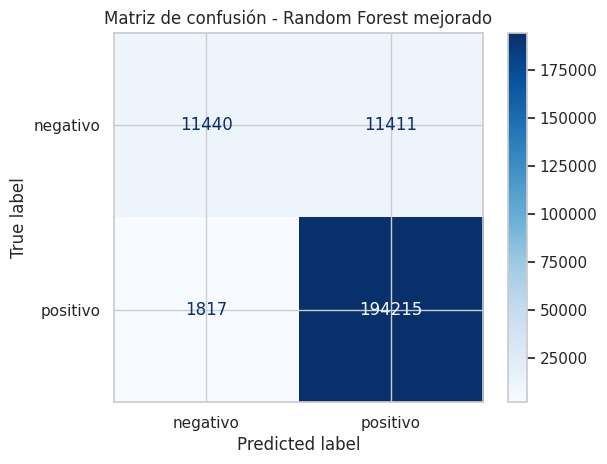

Modelo actualizado guardado en: ../models/sentiment_model_rf_v2.joblib


In [ ]:
# Paso 4: Entrenamiento y evaluación con Random Forest mejorado

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# 1. Entrenar el modelo
modelo_rf = RandomForestClassifier(n_estimators=100, random_state=42)
modelo_rf.fit(X_train, y_train)

# 2. Predecir sobre test
y_pred_rf = modelo_rf.predict(X_test)

# 3. Reporte de clasificación
print("Classification Report - Random Forest mejorado:\n")
print(classification_report(y_test, y_pred_rf))

# 4. Matriz de confusión
cm = confusion_matrix(y_test, y_pred_rf, labels=["negativo", "positivo"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["negativo", "positivo"])
disp.plot(cmap="Blues", values_format='g')
plt.title("Matriz de confusión - Random Forest mejorado")
plt.show()

# 5. Guardar modelo entrenado
output_model_path = "../models/sentiment_model_rf_v2.joblib"
joblib.dump(modelo_rf, output_model_path)
print(f"Modelo actualizado guardado en: {output_model_path}")


Classification Report - Random Forest:

              precision    recall  f1-score   support

    negativo      0.839     0.546     0.662     22851
    positivo      0.949     0.988     0.968    196032

    accuracy                          0.942    218883
   macro avg      0.894     0.767     0.815    218883
weighted avg      0.938     0.942     0.936    218883



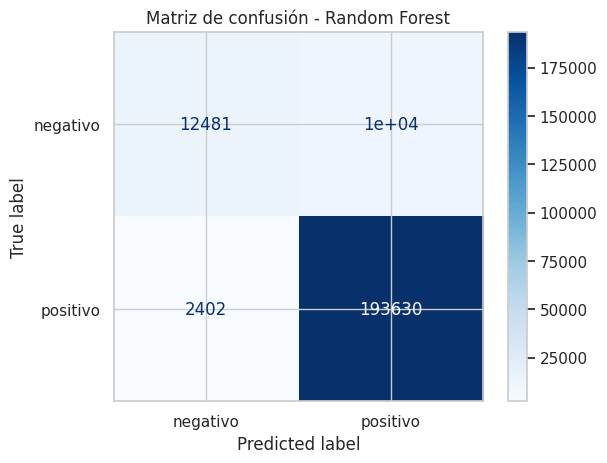

In [ ]:
# Paso 4: Entrenamiento del modelo y evaluación con Random Forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Inicializar el modelo
modelo_rf = RandomForestClassifier(
    n_estimators=100,       # Número de árboles (puedes aumentarlo si tienes tiempo de cómputo)
    max_depth=None,         # Profundidad máxima (None = crece hasta que las hojas sean puras)
    class_weight='balanced',# Pondera las clases automáticamente si están desbalanceadas
    random_state=42,
    n_jobs=-1               # Usa todos los núcleos disponibles
)

# 2. Entrenar el modelo
modelo_rf.fit(X_train, y_train)

# 3. Predecir sobre el conjunto de prueba
y_pred_rf = modelo_rf.predict(X_test)

# 4. Evaluación
print("Classification Report - Random Forest:\n")
print(classification_report(y_test, y_pred_rf, digits=3))

# 5. Matriz de confusión
cm_rf = confusion_matrix(y_test, y_pred_rf, labels=["negativo", "positivo"])
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["negativo", "positivo"])
disp_rf.plot(cmap="Blues")
plt.title("Matriz de confusión - Random Forest")
plt.show()


In [ ]:
# Bloque A: Guardar el modelo y el vectorizador entrenados

import joblib
import os

# Crear carpeta de salida si no existe
output_dir = "../models/sentiment_model_rf"
os.makedirs(output_dir, exist_ok=True)

# Guardar el modelo Random Forest
joblib.dump(modelo_rf, os.path.join(output_dir, "modelo_random_forest.joblib"))

# Guardar el vectorizador TF-IDF
joblib.dump(vectorizer, os.path.join(output_dir, "tfidf_vectorizer.joblib"))

print("Modelo y vectorizador guardados en:", output_dir)


Modelo y vectorizador guardados en: ../models/sentiment_model_rf


In [ ]:
# Bloque B: Cargar modelo y vectorizador entrenados

import joblib

# Ruta donde se guardaron
input_dir = "../models/sentiment_model_rf"

# Cargar el modelo
modelo_cargado = joblib.load(os.path.join(input_dir, "modelo_random_forest.joblib"))

# Cargar el vectorizador
vectorizer_cargado = joblib.load(os.path.join(input_dir, "tfidf_vectorizer.joblib"))


### Paso 5 · Entrenamiento y evaluación con Naive Bayes (ComplementNB)

En este paso se entrena un clasificador **Naive Bayes** utilizando la variante *ComplementNB*, que suele funcionar mejor que MultinomialNB con representaciones TF-IDF y en datasets desbalanceados.  

El flujo incluye:  
1. Inicialización y entrenamiento del modelo con los datos de entrenamiento.  
2. Predicción de etiquetas en el conjunto de prueba.  
3. Evaluación del rendimiento con métricas de clasificación (precision, recall, F1).  
4. Visualización de la **matriz de confusión** para analizar los aciertos y errores.  
5. Guardado del modelo entrenado en formato `.joblib` para su posterior uso.


In [ ]:
# Paso 5: Entrenamiento y evaluación con Naive Bayes (ComplementNB)

from sklearn.naive_bayes import ComplementNB  # suele ir mejor que MultinomialNB con TF-IDF
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib

# 1) Inicializar el modelo (ajusta alpha si quieres suavizado mayor/menor)
modelo_nb = ComplementNB(alpha=0.5)

# 2) Entrenar
modelo_nb.fit(X_train, y_train)

# 3) Predecir
y_pred_nb = modelo_nb.predict(X_test)

# 4) Evaluación
print("Classification Report - Naive Bayes (ComplementNB):\n")
print(classification_report(y_test, y_pred_nb, digits=3))

# 5) Matriz de confusión
cm_nb = confusion_matrix(y_test, y_pred_nb, labels=["negativo", "positivo"])
disp_nb = ConfusionMatrixDisplay(confusion_matrix=cm_nb, display_labels=["negativo", "positivo"])
disp_nb.plot(cmap="Greens", values_format='g')
plt.title("Matriz de confusión - Naive Bayes (ComplementNB)")
plt.show()


NameError: name 'X_train' is not defined